In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df
from taiko.performance import get_performance, get_pf_similarity

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,64
41,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,61


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
CONSIDERED_IDS = [1, 5, 33, 37, 60, 64, 98, 106, 140, 149, 179, 180, 240, 248, 253, 257, 287, 309, 322, 326]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# all
# CONSIDERED_IDS = play_record_df['id'].values

# full_combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

[1,
 5,
 33,
 37,
 60,
 64,
 98,
 106,
 140,
 149,
 179,
 180,
 240,
 248,
 253,
 257,
 287,
 309,
 322,
 326]

In [8]:
plays = []
with multiprocessing.Pool() as p:
    for _, play in tqdm(enumerate(p.imap(get_play, CONSIDERED_IDS)), total=len(CONSIDERED_IDS)):
        plays.append(play)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 20/20 [00:00<00:00, 127.58it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
45,chris,1,L_2018-09-26_133059.csv,R_2018-09-26_133100.csv,capture_2018_09_26_13_30_59,60,1,908230,76,10,0,86,44
49,chris,1,L_2018-09-26_134302.csv,R_2018-09-26_134304.csv,capture_2018_09_26_13_43_03,64,2,987660,85,1,0,86,50
81,cuxi,1,L_2018-09-25_160510.csv,R_2018-09-25_160512.csv,capture_2018_09_25_16_05_13,98,2,942410,77,9,0,86,63
89,cuxi,1,L_2018-09-25_163116.csv,R_2018-09-25_163117.csv,capture_2018_09_25_16_31_18,106,4,974110,81,5,0,86,67
121,eve,1,L_2018-09-26_175516.csv,R_2018-09-26_175517.csv,capture_2018_09_26_17_55_17,140,4,892060,67,19,0,86,39
129,eve,1,L_2018-09-28_163325.csv,R_2018-09-28_163326.csv,capture_2018_09_28_16_33_26,149,6,928410,75,11,0,86,38


In [8]:
pfs = []
for i_, id_ in tqdm(enumerate(CONSIDERED_IDS), total=len(CONSIDERED_IDS)):
    pid = id_
    pf = get_performance(pid)
    pfs.append(pf)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 20/20 [00:00<00:00, 48.87it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
45,chris,1,L_2018-09-26_133059.csv,R_2018-09-26_133100.csv,capture_2018_09_26_13_30_59,60,1,908230,76,10,0,86,44
49,chris,1,L_2018-09-26_134302.csv,R_2018-09-26_134304.csv,capture_2018_09_26_13_43_03,64,2,987660,85,1,0,86,50
81,cuxi,1,L_2018-09-25_160510.csv,R_2018-09-25_160512.csv,capture_2018_09_25_16_05_13,98,2,942410,77,9,0,86,63
89,cuxi,1,L_2018-09-25_163116.csv,R_2018-09-25_163117.csv,capture_2018_09_25_16_31_18,106,4,974110,81,5,0,86,67
121,eve,1,L_2018-09-26_175516.csv,R_2018-09-26_175517.csv,capture_2018_09_26_17_55_17,140,4,892060,67,19,0,86,39
129,eve,1,L_2018-09-28_163325.csv,R_2018-09-28_163326.csv,capture_2018_09_28_16_33_26,149,6,928410,75,11,0,86,38


In [8]:
plays = []
with multiprocessing.Pool() as p:
    for _, play in tqdm(enumerate(p.imap(get_play, CONSIDERED_IDS)), total=len(CONSIDERED_IDS)):
        plays.append(play)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 20/20 [00:00<00:00, 111.01it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
45,chris,1,L_2018-09-26_133059.csv,R_2018-09-26_133100.csv,capture_2018_09_26_13_30_59,60,1,908230,76,10,0,86,44
49,chris,1,L_2018-09-26_134302.csv,R_2018-09-26_134304.csv,capture_2018_09_26_13_43_03,64,2,987660,85,1,0,86,50
81,cuxi,1,L_2018-09-25_160510.csv,R_2018-09-25_160512.csv,capture_2018_09_25_16_05_13,98,2,942410,77,9,0,86,63
89,cuxi,1,L_2018-09-25_163116.csv,R_2018-09-25_163117.csv,capture_2018_09_25_16_31_18,106,4,974110,81,5,0,86,67
121,eve,1,L_2018-09-26_175516.csv,R_2018-09-26_175517.csv,capture_2018_09_26_17_55_17,140,4,892060,67,19,0,86,39
129,eve,1,L_2018-09-28_163325.csv,R_2018-09-28_163326.csv,capture_2018_09_28_16_33_26,149,6,928410,75,11,0,86,38


In [9]:
HANDS = ['L', 'R']
# _K = 370
# SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, ZERO_ADJ_COL)]
# SIMILARITY_COLUMNS = [str(k) + '_' + b for k, b in product(range(_K), SIMILARITY_COLUMNS)]
# SIMILARITY_COLUMNS = list(pfs[0].columns)[1:]
SIMILARITY_COLUMNS = ['acc_dtw', 'gyr_dtw']
# SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, SIMILARITY_COLUMNS)]
SIMILARITY_COLUMNS

['acc_dtw', 'gyr_dtw']

In [10]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_similarity, product(plays, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)

similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id'] + SIMILARITY_COLUMNS
similarity_df

,a_id,b_id,acc_dtw,gyr_dtw
0,1,1,0.000000,0.000000
1,1,5,3585.160502,2969.436048
2,1,33,6005.424808,5313.993529
3,1,37,6416.158144,6639.918188
4,1,60,6394.835715,5464.473590
5,1,64,6552.871861,4479.187358
6,1,98,6972.962811,6205.969944
7,1,106,6307.833639,6297.597518
8,1,140,6373.170802,6404.459955
9,1,149,7424.952731,7133.441080


/usr/bin/anaconda3/envs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


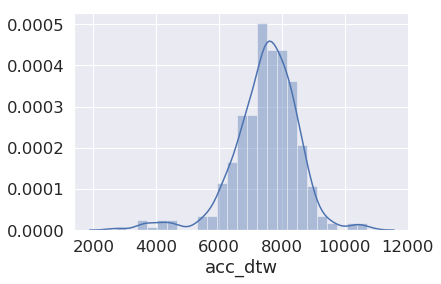

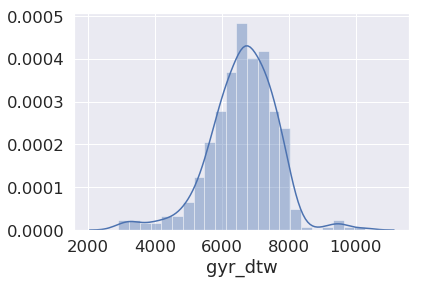

In [26]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
for col in SIMILARITY_COLUMNS:
    sns.distplot(dtw_df[col])
    plt.show()
dtw_df.to_csv('dtw_df@pf_merge_ex.csv', index=False)

In [12]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
1,1,5,-3.751865,-3.585276,-3.668571
2,1,33,-1.424374,-1.279496,-1.351935
3,1,37,-1.029385,0.024498,-0.502443
4,1,60,-1.049890,-1.131505,-1.090698
5,1,64,-0.897912,-2.100495,-1.499204
6,1,98,-0.493924,-0.402273,-0.448098
7,1,106,-1.133558,-0.312160,-0.722859
8,1,140,-1.070725,-0.207065,-0.638895
9,1,149,-0.059260,0.509859,0.225299
10,1,179,0.625941,0.584588,0.605264


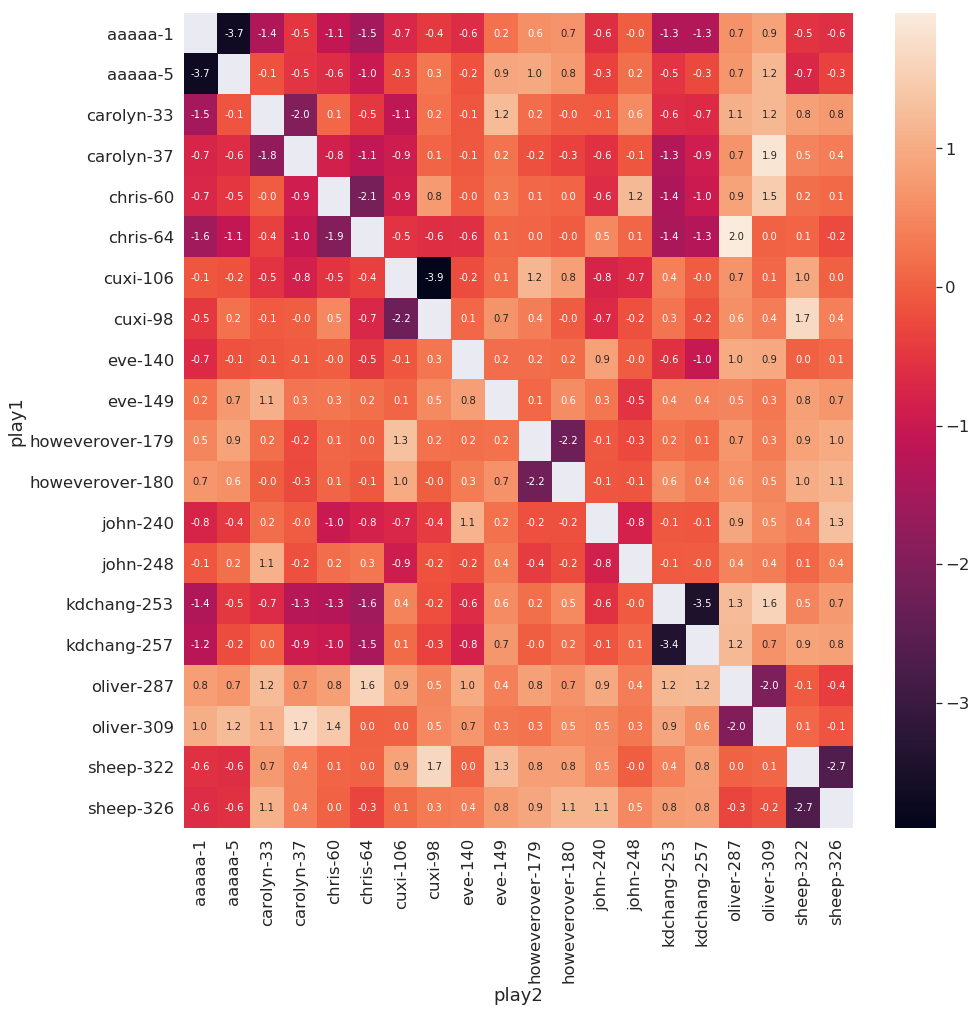

In [13]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

In [14]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)

scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
for col in SIMILARITY_COLUMNS:
    dtw_df[col] -= dtw_df.min(axis=0)[col]
    
dtw_df['norm_sim'] = np.sqrt(np.square(dtw_df[SIMILARITY_COLUMNS]).sum(axis=1))
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
1,1,5,0.817408,0.062029,0.819759
2,1,33,3.144899,2.367809,3.936611
3,1,37,3.539888,3.671803,5.100289
4,1,60,3.519383,2.515800,4.326119
5,1,64,3.671361,1.546810,3.983907
6,1,98,4.075349,3.245032,5.209482
7,1,106,3.435716,3.335144,4.788249
8,1,140,3.498548,3.440239,4.906637
9,1,149,4.510013,4.157163,6.133696
10,1,179,5.195214,4.231892,6.700684


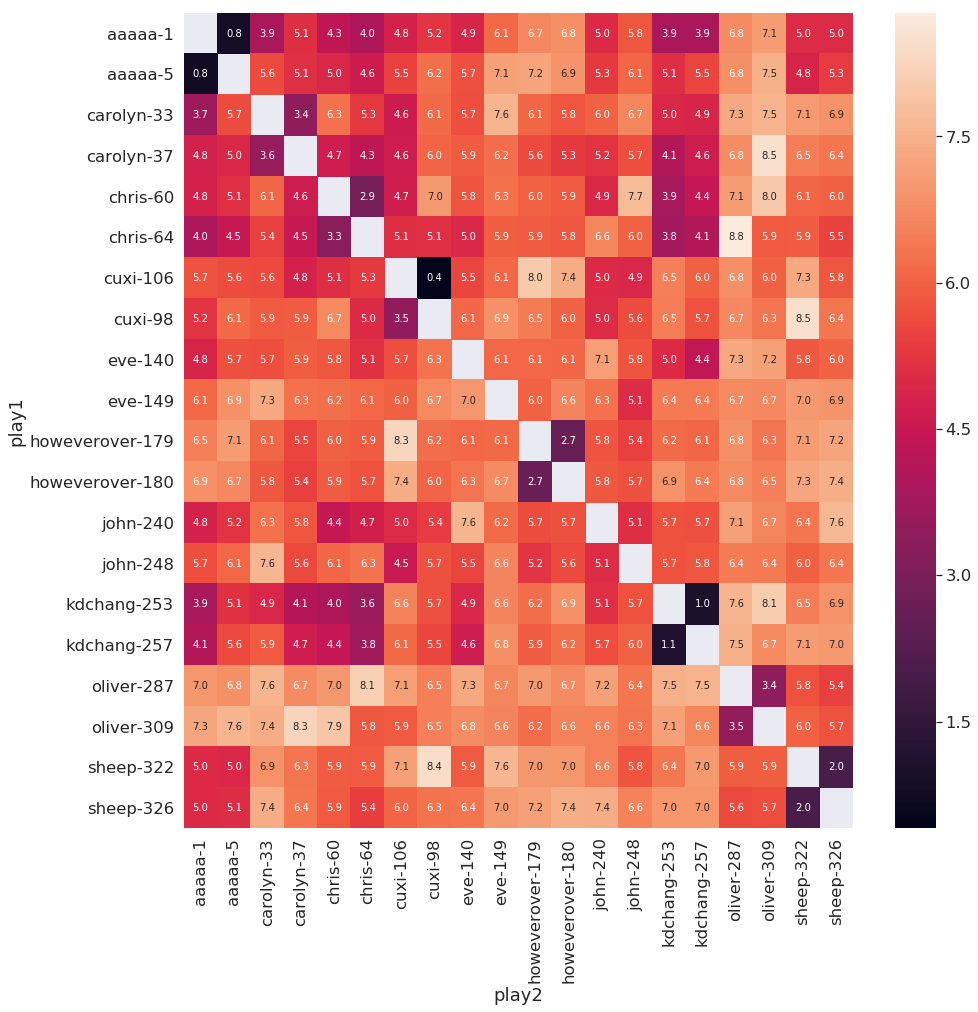

In [15]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# LGBM

In [16]:
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
score_right_df = play_record_df.copy()
score_right_df = score_right_df[['score', 'id']]

score_df = dtw_df.copy()
score_df = score_df.merge(score_right_df, left_on='a_id', right_on='id', how='inner')
score_df = score_df.merge(score_right_df, left_on='b_id', right_on='id', how='inner')
score_df = score_df[score_df['a_id'] < score_df['b_id']].reset_index(drop=True)
score_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
score_df['score_dif'] = np.abs(score_df['score_x'] - score_df['score_y'])
score_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
score_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim,score_dif
0,1,5,0.817408,0.062029,0.819759,14250
1,1,33,3.144899,2.367809,3.936611,29550
2,5,33,4.160746,3.760825,5.608531,43800
3,1,37,3.539888,3.671803,5.100289,61150
4,5,37,4.011244,3.171331,5.113455,75400
5,33,37,3.249285,1.057290,3.416975,31600
6,1,60,3.519383,2.515800,4.326119,66880
7,5,60,3.905803,3.045838,4.953021,81130
8,33,60,5.613440,2.798172,6.272198,37330
9,37,60,3.738911,2.785398,4.662392,5730


In [18]:
train_df = score_df.drop(['a_id', 'b_id', 'norm_sim'], axis=1).copy()
x = train_df.drop('score_dif', axis=1)
y = train_df['score_dif']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.5)

train_df

,acc_dtw,gyr_dtw,score_dif
0,0.817408,0.062029,14250
1,3.144899,2.367809,29550
2,4.160746,3.760825,43800
3,3.539888,3.671803,61150
4,4.011244,3.171331,75400
5,3.249285,1.057290,31600
6,3.519383,2.515800,66880
7,3.905803,3.045838,81130
8,5.613440,2.798172,37330
9,3.738911,2.785398,5730


In [19]:
train_set = lgb.Dataset(x_train, y_train)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'application': 'mse',
#     'min_data_in_leaf': 3,
#     'max_depth': 100,
#     'num_leaves': 2 ** 7,
    'min_data': 1,
    'verbosity': 0,
    'metric': ['l2']
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

model = lgb.train(params, train_set=train_set, valid_sets=watchlist,
                  num_boost_round=2000, verbose_eval=20, early_stopping_rounds=100)
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's l2: 8.12949e+09
[40]	valid_0's l2: 9.01647e+09
[60]	valid_0's l2: 9.27433e+09
[80]	valid_0's l2: 9.35095e+09
[100]	valid_0's l2: 9.38535e+09
Early stopping, best iteration is:
[1]	valid_0's l2: 6.99071e+09


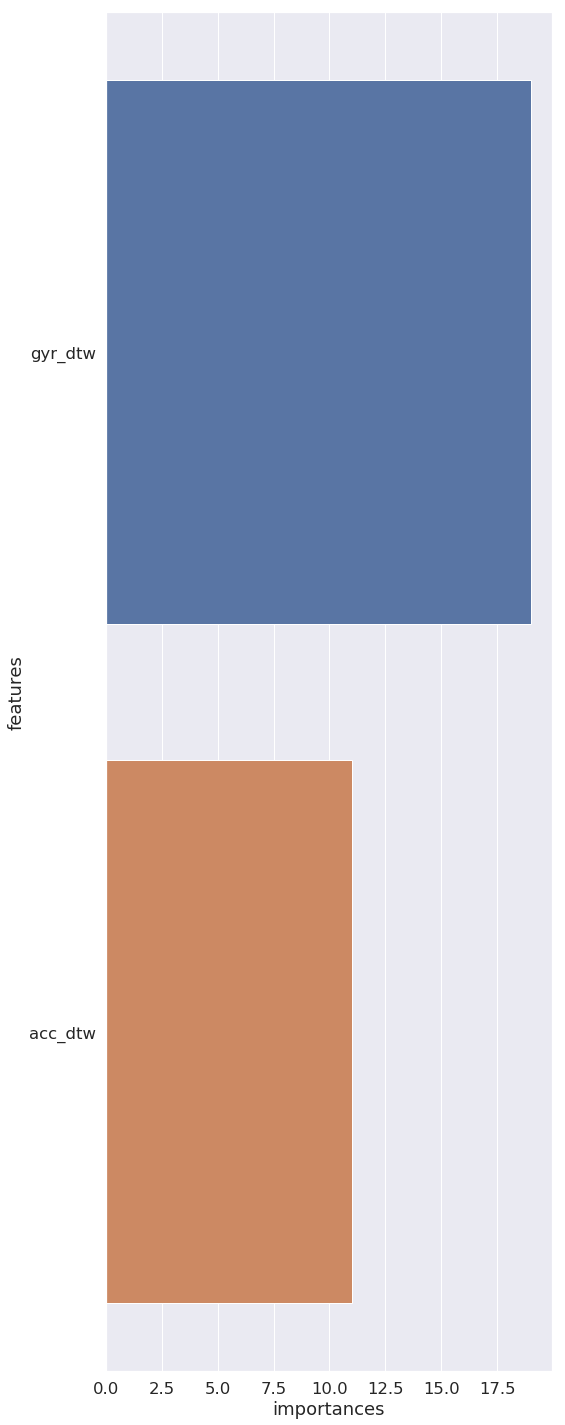

In [20]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'score_dif'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)
plot_df = plot_df.head(30)
plt.figure(figsize=(8, 25))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

In [21]:
compare_df = pd.DataFrame(data={
    'pred': y_pred,
    'test': y_test,
})
compare_df['dif'] = np.abs(compare_df['pred'] - compare_df['test'])
compare_df.reset_index(inplace=True)
compare_df

,index,pred,test,dif
0,108,58249.500006,400,57849.500006
1,74,56071.224978,40100,15971.224978
2,161,56760.541652,70450,13689.458348
3,95,58249.500006,234240,175990.499994
4,123,56451.874985,32500,23951.874985
5,71,59405.874969,135700,76294.125031
6,18,55723.374969,28450,27273.374969
7,124,61243.375164,38230,23013.375164
8,143,56760.541652,91010,34249.458348
9,7,56240.874969,81130,24889.125031


In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
print('The mae of prediction is:', mean_absolute_error(y_test, y_pred))

The mae of prediction is: 56620.04079512578


In [24]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 88207.74674574261


In [25]:
print('The mape of prediction is:', mean_absolute_percentage_error(y_test, y_pred))

The mape of prediction is: 532.1248312606042
